In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#https://ipython.org/ipython-doc/3/config/extensions/autoreload.html
# Reload all modules (except those excluded by %aimport) every time before executing the Python code typed.


In [28]:
import logging 
import joblib
from datetime import datetime

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

import algo_ecg.data
import algo_ecg.preprocessing
#import algo_ecg.model
from algo_ecg.feature_transformer import \
    calculate_hrv_based_on_peak_intervals, \
    calculate_hrv_based_on_peak_intervals3, \
    FindPeaksCustomTransformer, select_cols, \
    AllFeatureCustomTransformer, \
    filter_interpolation_calculate_fre_domain_features, \
    generate_time_fre_domain_features, \
    functional_return_all_features

from sklearn.base import BaseEstimator, TransformerMixin
import sklearn.model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer, StandardScaler


from sklearn.metrics import RocCurveDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV

In [3]:
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)
logging.getLogger('matplotlib.font_manager').disabled = True
plt.rcParams['figure.figsize'] = [12, 8]

# Load data

In [4]:
X_in, y = algo_ecg.data.import_physionet_data('../data', num_files_to_read=1000)
#X_in, y = algo_ecg.data.import_physionet_data('../data')

In [5]:
X = algo_ecg.preprocessing.preprocess(X_in)

DEBUG:root:
DEBUG:root:i=0: 37 outliers found
DEBUG:root:
DEBUG:root:i=1: 48 outliers found
DEBUG:root:
DEBUG:root:i=2: 6 outliers found
DEBUG:root:i=2: flipped values
DEBUG:root:
DEBUG:root:i=3: 45 outliers found
DEBUG:root:i=3: flipped values
DEBUG:root:
DEBUG:root:i=4: 99 outliers found
DEBUG:root:
DEBUG:root:i=5: 18 outliers found
DEBUG:root:
DEBUG:root:i=6: 44 outliers found
DEBUG:root:
DEBUG:root:i=7: 28 outliers found
DEBUG:root:
DEBUG:root:i=8: 53 outliers found
DEBUG:root:i=8: flipped values
DEBUG:root:
DEBUG:root:i=9: 19 outliers found
DEBUG:root:
DEBUG:root:i=10: 39 outliers found
DEBUG:root:
DEBUG:root:i=11: 119 outliers found
DEBUG:root:
DEBUG:root:i=13: 101 outliers found
DEBUG:root:
DEBUG:root:i=14: 92 outliers found
DEBUG:root:i=14: flipped values
DEBUG:root:
DEBUG:root:i=15: 61 outliers found
DEBUG:root:
DEBUG:root:i=16: 92 outliers found
DEBUG:root:
DEBUG:root:i=17: 13 outliers found
DEBUG:root:
DEBUG:root:i=18: 22 outliers found
DEBUG:root:
DEBUG:root:i=19: 99 outlie

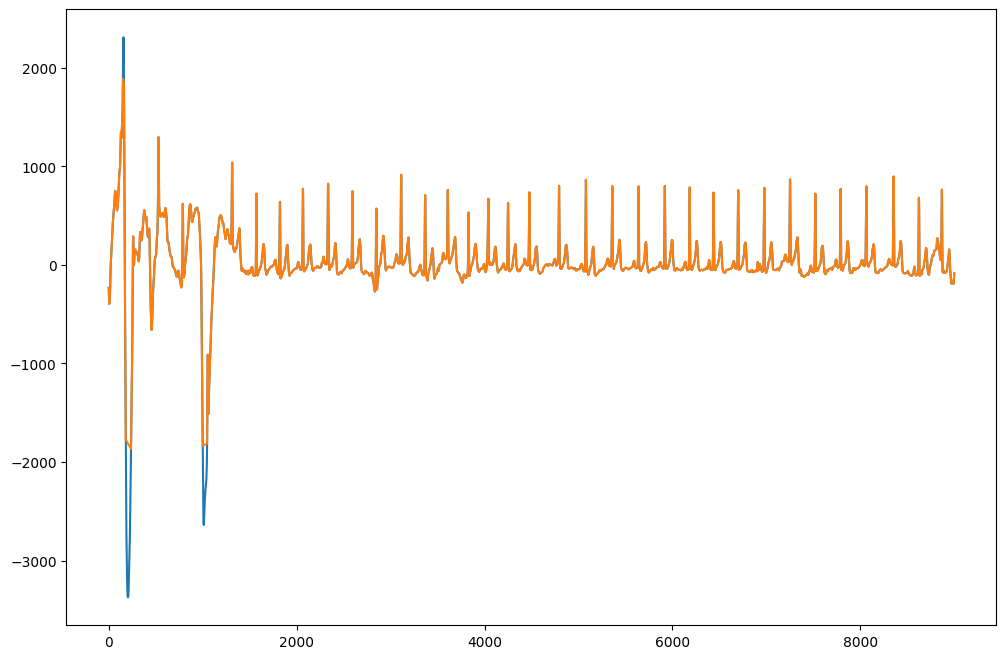

In [6]:
plt.plot(X_in[71])
plt.plot(X[71])

# Train test split

In [7]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=.7)

In [8]:
y_train

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [9]:
len(X_train[0])

9000

In [10]:
slice_length = len(X_train[0])
X_train = np.concatenate(X_train).reshape(-1, slice_length, 1)
X_test = np.concatenate(X_test).reshape(-1, slice_length, 1)

In [11]:
slice_length

9000

In [12]:
X_train_pd = pd.DataFrame.from_records(X_train)
X_test_pd = pd.DataFrame.from_records(X_test)
                 

In [13]:
X_train_pd.shape

(482, 9000)

In [14]:
X_train_pd.head()

,0,1,2,3,4,5,6,7,8,9,...,8990,8991,8992,8993,8994,8995,8996,8997,8998,8999
0,[24.0],[35.0],[44.0],[53.0],[64.0],[83.0],[107.0],[139.0],[184.0],[250.0],...,[-132.0],[-130.0],[-128.0],[-124.0],[-120.0],[-115.0],[-106.0],[-89.0],[-70.0],[-53.0]
1,[36.0],[45.0],[55.0],[63.0],[70.0],[76.0],[82.0],[86.0],[91.0],[98.0],...,[-10.0],[-12.0],[-15.0],[-17.0],[-18.0],[-20.0],[-21.0],[-20.0],[-17.0],[-10.0]
2,[-397.0],[-469.0],[-532.0],[-597.0],[-648.0],[-667.0],[-655.0],[-645.0],[-641.0],[-637.0],...,[-143.0],[-136.0],[-125.0],[-103.0],[-83.0],[-62.0],[-42.0],[-23.0],[-4.0],[12.0]
3,[166.0],[200.0],[233.0],[267.0],[285.0],[289.0],[291.0],[292.0],[293.0],[293.0],...,[44.0],[42.0],[40.0],[37.0],[34.0],[25.0],[10.0],[0.0],[-8.0],[-14.0]
4,[122.0],[172.0],[220.0],[254.0],[288.0],[312.0],[320.0],[326.0],[331.0],[328.0],...,[-43.0],[-112.0],[-181.0],[-233.0],[-257.0],[-254.0],[-221.0],[-178.0],[-158.0],[-148.0]


In [15]:
X_train_pd_plot = X_train_pd
#peaks, _ = find_peaks(X_train_pd.iloc[1, ], height = 0, distance = 150)
#np.diff(peaks)
X_train_pd_plot['peaks'] = X_train_pd_plot.apply(find_peaks, height = 0, distance = 150, axis = 1)

In [16]:
len(X_train_pd_plot.iloc[0, ]['peaks'][0])

56

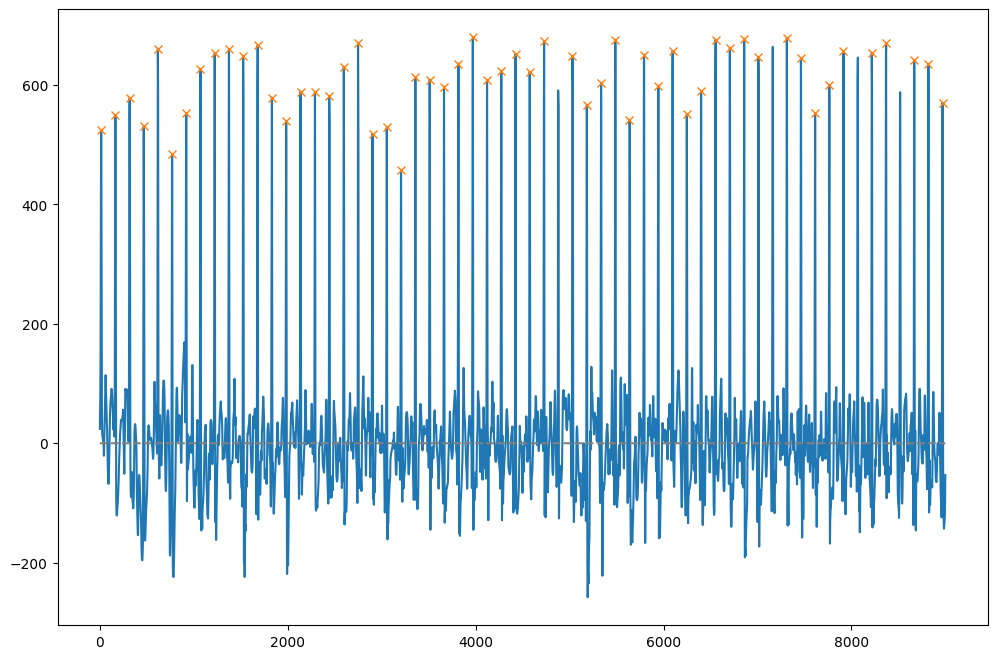

In [17]:

plt.plot(X_train_pd_plot.iloc[0, 0:9000])
plt.plot(X_train_pd_plot.iloc[0, ]['peaks'][0], X_train_pd_plot.iloc[0, ]['peaks'][1]['peak_heights'], "x")
plt.plot(np.zeros_like(X_train_pd_plot.iloc[0, 0:9000]), "--", color="gray")
plt.show()


# Pipeline 

In [18]:
X_train_pd = pd.DataFrame.from_records(X_train)
X_test_pd = pd.DataFrame.from_records(X_test)

In [19]:
tf1 = X_train_pd.apply(calculate_hrv_based_on_peak_intervals, axis=1)

In [29]:
tf2 = X_train_pd.apply(calculate_hrv_based_on_peak_intervals3, axis=1) 

In [68]:
tf2.shape

(482, 12)

In [23]:
freq_features = X_train_pd.apply(filter_interpolation_calculate_fre_domain_features, axis=1) 

In [24]:
freq_features.shape

(482, 10)

In [35]:
all = X_train_pd.apply(generate_time_fre_domain_features, axis=1) 

In [36]:
all.shape

(482, 22)

In [37]:
all.iloc[:5, ]

,Mean_RR_ms,STD_RR_ms,Mean_HR_beats_per_min_kubio,Mean_HR_beats_per_min,STD_HR_beats_per_min,Min_HR_beats_per_min,Max_HR_beats_per_min,RMSSD_ms,NN50,pNN50,...,Power_VLF_ms2,Power_LF_ms2,Power_HF_ms2,Power_Total_ms2,LF_HF_ratio,Peak_VLF_Hz,Peak_LF_Hz,Peak_HF_Hz,Fraction_LF_nu,Fraction_HF_nu
0,505.932203,3.475380,118.592965,118.598565,0.815261,116.883117,120.000000,3.275358,0,0.000000,...,0.131190,0.043900,0.210294,0.385384,0.208754,0.033333,0.100000,0.300000,17.270147,82.729853
1,823.611111,52.998806,72.849916,73.287780,6.859920,68.965517,112.500000,62.144225,7,19.444444,...,3.529128,1.335422,3.333556,8.198106,0.400600,0.000000,0.100000,0.333333,28.602020,71.397980
2,723.983740,29.725205,82.874789,83.042105,4.098894,78.602620,106.508876,33.586538,1,2.439024,...,5.385239,5.542355,4.751153,15.678748,1.166528,0.033333,0.066667,0.300000,53.843208,46.156792
3,597.600000,111.155627,100.401606,102.986163,14.296297,57.692308,120.000000,169.014752,24,48.000000,...,8.498986,20.654748,42.431706,71.585440,0.486776,0.034783,0.104348,0.278261,32.740386,67.259614
4,686.589147,120.959746,87.388506,89.958900,15.174556,57.507987,119.205298,123.642898,11,25.581395,...,49.845202,62.573644,253.142710,365.561556,0.247187,0.034783,0.069565,0.313043,19.819576,80.180424


(array([ 2.,  9., 11., 12., 16., 17., 27., 22., 24., 23., 19., 15., 16.,
        21., 15., 23., 13., 26., 18., 14., 14.,  8., 10., 13., 14.,  7.,
        13.,  0., 10.,  8.,  6.,  5.,  6.,  6.,  5.,  2.,  2.,  0.,  5.,
         2.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([ 61.08597285,  62.23611269,  63.38625253,  64.53639237,
         65.68653221,  66.83667205,  67.98681189,  69.13695173,
         70.28709157,  71.43723141,  72.58737125,  73.73751108,
         74.88765092,  76.03779076,  77.1879306 ,  78.33807044,
         79.48821028,  80.63835012,  81.78848996,  82.9386298 ,
         84.08876964,  85.23890948,  86.38904932,  87.53918916,
         88.689329  ,  89.83946884,  90.98960868,  92.13974852,
         93.28988836,  94.4400282 ,  95.59016803,  96.74030787,
         97.89044771,  99.04058755, 100.19072739, 101.34086723,
        102.49100707, 103.64114691, 104.79128675, 105.94142659,
        107.09156643, 108.24170627, 109.39184611, 110.54198595,
        111.

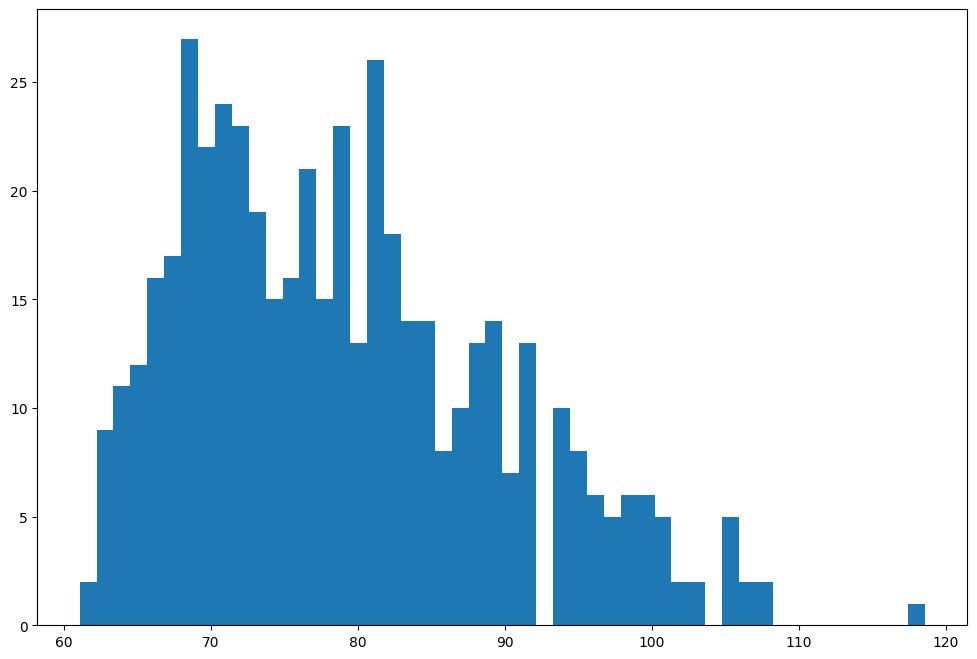

In [46]:
plt.hist(all.Mean_HR_beats_per_min_kubio, bins = 50)

### Functional transformer
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

In [38]:
#    ('feature_select_manual',FunctionTransformer(select_cols, kw_args={"col_names": ['rmssd']})), 

preprocessor_pipeline = Pipeline(
    steps = [
        ('features_all',FunctionTransformer(functional_return_all_features, kw_args = {'axis': 1})), 
    ]
)

In [39]:
transformed_df = preprocessor_pipeline.fit_transform(X_train_pd)
transformed_df

,Mean_RR_ms,STD_RR_ms,Mean_HR_beats_per_min_kubio,Mean_HR_beats_per_min,STD_HR_beats_per_min,Min_HR_beats_per_min,Max_HR_beats_per_min,RMSSD_ms,NN50,pNN50,...,Power_VLF_ms2,Power_LF_ms2,Power_HF_ms2,Power_Total_ms2,LF_HF_ratio,Peak_VLF_Hz,Peak_LF_Hz,Peak_HF_Hz,Fraction_LF_nu,Fraction_HF_nu
0,505.932203,3.475380,118.592965,118.598565,0.815261,116.883117,120.000000,3.275358,0,0.000000,...,0.131190,0.043900,0.210294,0.385384,0.208754,0.033333,0.100000,0.300000,17.270147,82.729853
1,823.611111,52.998806,72.849916,73.287780,6.859920,68.965517,112.500000,62.144225,7,19.444444,...,3.529128,1.335422,3.333556,8.198106,0.400600,0.000000,0.100000,0.333333,28.602020,71.397980
2,723.983740,29.725205,82.874789,83.042105,4.098894,78.602620,106.508876,33.586538,1,2.439024,...,5.385239,5.542355,4.751153,15.678748,1.166528,0.033333,0.066667,0.300000,53.843208,46.156792
3,597.600000,111.155627,100.401606,102.986163,14.296297,57.692308,120.000000,169.014752,24,48.000000,...,8.498986,20.654748,42.431706,71.585440,0.486776,0.034783,0.104348,0.278261,32.740386,67.259614
4,686.589147,120.959746,87.388506,89.958900,15.174556,57.507987,119.205298,123.642898,11,25.581395,...,49.845202,62.573644,253.142710,365.561556,0.247187,0.034783,0.069565,0.313043,19.819576,80.180424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,846.380952,96.787679,70.890064,72.158574,11.174475,62.717770,110.429448,145.467468,8,22.857143,...,4.640127,7.650260,81.790510,94.080897,0.093535,0.032787,0.131148,0.196721,8.553437,91.446563
478,708.174603,16.890597,84.724868,84.771436,1.954625,77.253219,89.108911,16.478614,2,4.761905,...,1.451216,2.555815,2.305238,6.312270,1.108699,0.033613,0.067227,0.168067,52.577392,47.422608
479,784.561404,36.638115,76.475850,76.696129,4.733305,74.380165,104.651163,41.198268,1,2.631579,...,0.190214,0.054395,9.511726,9.756334,0.005719,0.033058,0.132231,0.264463,0.568621,99.431379
480,774.122807,200.102947,77.507082,83.488986,23.416570,52.785924,120.000000,178.780487,18,47.368421,...,642.516689,947.978215,391.269007,1981.763911,2.422830,0.033898,0.067797,0.203390,70.784408,29.215592


### Customise the base transformer class 

In [40]:
preprocessor_pipeline = Pipeline(
    steps = [
        ('features_all',AllFeatureCustomTransformer(axis = 1)), 
    ]
)


In [41]:
transformed_df = preprocessor_pipeline.fit_transform(X_train_pd)

In [42]:
transformed_df

,Mean_RR_ms,STD_RR_ms,Mean_HR_beats_per_min_kubio,Mean_HR_beats_per_min,STD_HR_beats_per_min,Min_HR_beats_per_min,Max_HR_beats_per_min,RMSSD_ms,NN50,pNN50,...,Power_VLF_ms2,Power_LF_ms2,Power_HF_ms2,Power_Total_ms2,LF_HF_ratio,Peak_VLF_Hz,Peak_LF_Hz,Peak_HF_Hz,Fraction_LF_nu,Fraction_HF_nu
0,505.932203,3.475380,118.592965,118.598565,0.815261,116.883117,120.000000,3.275358,0,0.000000,...,0.131190,0.043900,0.210294,0.385384,0.208754,0.033333,0.100000,0.300000,17.270147,82.729853
1,823.611111,52.998806,72.849916,73.287780,6.859920,68.965517,112.500000,62.144225,7,19.444444,...,3.529128,1.335422,3.333556,8.198106,0.400600,0.000000,0.100000,0.333333,28.602020,71.397980
2,723.983740,29.725205,82.874789,83.042105,4.098894,78.602620,106.508876,33.586538,1,2.439024,...,5.385239,5.542355,4.751153,15.678748,1.166528,0.033333,0.066667,0.300000,53.843208,46.156792
3,597.600000,111.155627,100.401606,102.986163,14.296297,57.692308,120.000000,169.014752,24,48.000000,...,8.498986,20.654748,42.431706,71.585440,0.486776,0.034783,0.104348,0.278261,32.740386,67.259614
4,686.589147,120.959746,87.388506,89.958900,15.174556,57.507987,119.205298,123.642898,11,25.581395,...,49.845202,62.573644,253.142710,365.561556,0.247187,0.034783,0.069565,0.313043,19.819576,80.180424
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
477,846.380952,96.787679,70.890064,72.158574,11.174475,62.717770,110.429448,145.467468,8,22.857143,...,4.640127,7.650260,81.790510,94.080897,0.093535,0.032787,0.131148,0.196721,8.553437,91.446563
478,708.174603,16.890597,84.724868,84.771436,1.954625,77.253219,89.108911,16.478614,2,4.761905,...,1.451216,2.555815,2.305238,6.312270,1.108699,0.033613,0.067227,0.168067,52.577392,47.422608
479,784.561404,36.638115,76.475850,76.696129,4.733305,74.380165,104.651163,41.198268,1,2.631579,...,0.190214,0.054395,9.511726,9.756334,0.005719,0.033058,0.132231,0.264463,0.568621,99.431379
480,774.122807,200.102947,77.507082,83.488986,23.416570,52.785924,120.000000,178.780487,18,47.368421,...,642.516689,947.978215,391.269007,1981.763911,2.422830,0.033898,0.067797,0.203390,70.784408,29.215592


# Put it together

In [47]:
pipe = Pipeline(steps=[
#    ('peaks', FindPeaksCustomTransformer (axis=1)), 
#    ('feature_select_manual',FunctionTransformer(select_cols, kw_args={"col_names": ['rmssd']})), 
    ('features_all',AllFeatureCustomTransformer(axis = 1)), 
    ('feature_selection', SelectFromModel(LinearSVC(dual="auto", penalty="l1", C = 0.01))), 
    ('standardscaler', StandardScaler()), 
    ("lr", LogisticRegression(max_iter=1000, tol=0.1, class_weight = "balanced"))
     ]
    )


In [48]:
pipe.steps

[('features_all', AllFeatureCustomTransformer()),
 ('feature_selection',
  SelectFromModel(estimator=LinearSVC(C=0.01, dual='auto', penalty='l1'))),
 ('standardscaler', StandardScaler()),
 ('lr', LogisticRegression(class_weight='balanced', max_iter=1000, tol=0.1))]

In [49]:
pipe.fit(X_train_pd, y_train)

/Users/jessie/.pyenv/versions/cinc/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('features_all', AllFeatureCustomTransformer()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=0.01, dual='auto',
                                                     penalty='l1'))),
                ('standardscaler', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    tol=0.1))])

In [50]:
y_train_pred = pipe.predict(X_train_pd)
y_test_pred = pipe.predict(X_test_pd)
y_test_pred_prob = pipe.predict_proba(X_test_pd)
y_test_pred_prob[:, 1]

array([9.98515331e-01, 7.42034882e-01, 2.94442339e-02, 5.66453955e-03,
       2.73443269e-02, 5.58969832e-01, 3.03806045e-02, 5.61381383e-02,
       1.72881699e-02, 6.51659441e-02, 3.04467214e-02, 9.86210114e-01,
       8.03736345e-02, 7.57563880e-01, 8.10501140e-02, 2.89218356e-01,
       2.14049369e-02, 3.07881102e-02, 2.59210689e-02, 1.77744474e-01,
       9.90201992e-01, 6.89449181e-01, 3.59786925e-03, 8.57605316e-01,
       1.08367553e-02, 3.40854408e-02, 6.46534990e-02, 6.85979215e-01,
       2.39031328e-02, 1.43144122e-01, 3.78514926e-02, 9.69001057e-01,
       8.25234773e-02, 9.69133992e-04, 9.66754523e-01, 3.05636304e-02,
       1.49976600e-01, 9.44511245e-01, 8.05372692e-01, 4.90165185e-01,
       2.06268278e-01, 9.66327029e-01, 2.63986072e-02, 4.79400637e-01,
       5.00620097e-02, 5.96674501e-02, 2.91785288e-02, 9.89748910e-01,
       4.81028139e-01, 8.12164576e-01, 1.23041207e-02, 9.99786581e-01,
       9.26675829e-01, 4.23024491e-02, 4.91624666e-02, 9.99771023e-01,
      

# Validation 

In [51]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, roc_curve, confusion_matrix
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.88      0.93       174
           1       0.61      0.97      0.75        34

    accuracy                           0.89       208
   macro avg       0.80      0.92      0.84       208
weighted avg       0.93      0.89      0.90       208



In [52]:
fpr, tpr, _ = sklearn.metrics.roc_curve(y_test, y_test_pred_prob[:, 1])
sklearn.metrics.auc(x=fpr, y=tpr)

0.9834347532116294

In [53]:
fpr, tpr

(array([0.        , 0.        , 0.        , 0.00574713, 0.00574713,
        0.02298851, 0.02298851, 0.04022989, 0.04022989, 0.06321839,
        0.06321839, 0.0862069 , 0.0862069 , 0.09195402, 0.09195402,
        0.14942529, 0.14942529, 1.        ]),
 array([0.        , 0.02941176, 0.64705882, 0.64705882, 0.76470588,
        0.76470588, 0.82352941, 0.82352941, 0.85294118, 0.85294118,
        0.91176471, 0.91176471, 0.94117647, 0.94117647, 0.97058824,
        0.97058824, 1.        , 1.        ]))

Text(0, 0.5, 'True positive rate / Recall / Sensitivity')

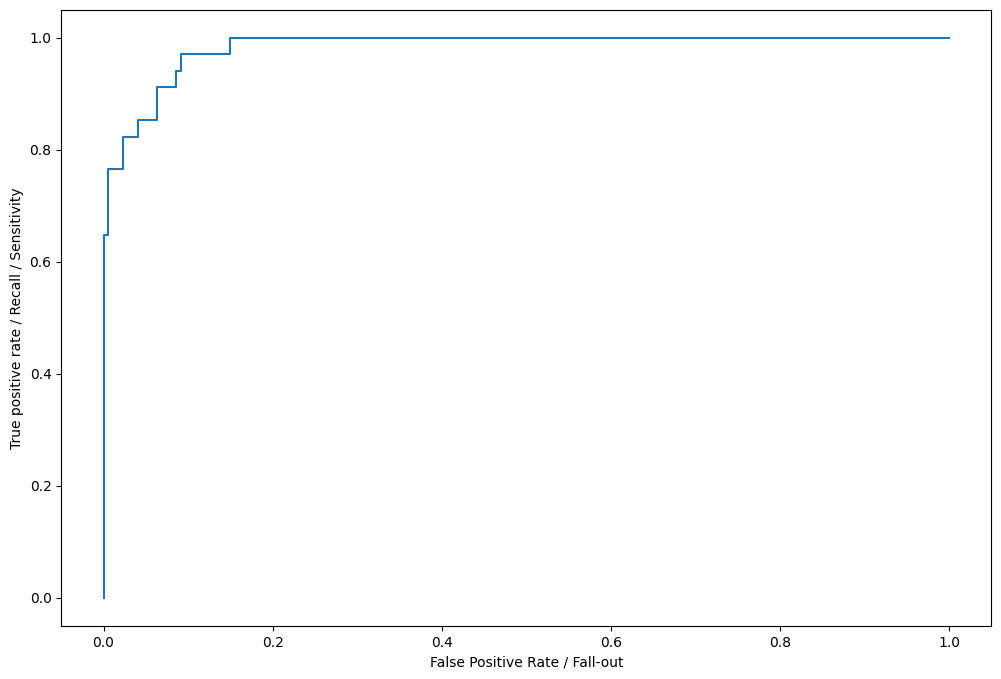

In [85]:
plt.plot(fpr, tpr)
plt.xlabel ("False Positive Rate / Fall-out")
plt.ylabel ("True positive rate / Recall / Sensitivity")

In [55]:
tn, fp, fn, tp = confusion_matrix(y_test, y_test_pred).ravel()
tn, fp, fn, tp

(153, 21, 1, 33)

In [56]:
CUTOFF = .5
acc = sklearn.metrics.accuracy_score(y_true=y_test, y_pred=(y_test_pred > CUTOFF))
prec = sklearn.metrics.precision_score(y_true=y_test, y_pred=(y_test_pred > CUTOFF))
rec = np.sum(y_test * (y_test_pred > CUTOFF).reshape((-1,))) / np.sum(y_test)
sens = np.sum((y_test + (y_test_pred > CUTOFF).reshape((-1,))) == 0) / np.sum(y_test == 0)
acc, prec, rec, sens

(0.8942307692307693,
 0.6111111111111112,
 0.9705882352941176,
 0.8793103448275862)

In [57]:
pipe.decision_function

<bound method Pipeline.decision_function of Pipeline(steps=[('features_all', AllFeatureCustomTransformer()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=0.01, dual='auto',
                                                     penalty='l1'))),
                ('standardscaler', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    tol=0.1))])>

In [74]:
pipe.named_steps.feature_selection.get_feature_names_out()

array(['STD_RR_ms', 'Mean_HR_beats_per_min_kubio',
       'Mean_HR_beats_per_min', 'Min_HR_beats_per_min',
       'Max_HR_beats_per_min', 'RMSSD_ms', 'pNN50', 'pNN70',
       'Power_VLF_ms2', 'Power_LF_ms2', 'Power_HF_ms2', 'Power_Total_ms2',
       'Fraction_HF_nu'], dtype=object)

In [59]:
pipe.named_steps.feature_selection.get_support()

array([False,  True,  True,  True, False,  True,  True,  True, False,
        True, False,  True,  True,  True,  True,  True, False, False,
       False, False, False,  True])

In [79]:
pipe.named_steps.lr.coef_[0]

array([-0.51477537, -0.0249042 , -0.2893863 ,  0.50360639, -1.09647725,
        1.46686978,  1.49595685,  1.36051985, -0.69159224,  0.27035112,
       -0.58506941, -0.42588237,  0.40435928])

In [80]:
feature_importance = pd.DataFrame({
    'feature_name': list(pipe.named_steps.feature_selection.get_feature_names_out()), 
    'coef': list(pipe.named_steps.lr.coef_[0])})

In [82]:
feature_importance.sort_values(by=['coef'])

,feature_name,coef
4,Max_HR_beats_per_min,-1.096477
8,Power_VLF_ms2,-0.691592
10,Power_HF_ms2,-0.585069
0,STD_RR_ms,-0.514775
11,Power_Total_ms2,-0.425882
2,Mean_HR_beats_per_min,-0.289386
1,Mean_HR_beats_per_min_kubio,-0.024904
9,Power_LF_ms2,0.270351
12,Fraction_HF_nu,0.404359
3,Min_HR_beats_per_min,0.503606


In [60]:
filename = 'initial_model_pipeline_time_freq_1K_{}.pkl'.format(datetime.now().strftime('%Y-%m-%d'))

In [83]:
# This would work after removing autoloader,  
# see stackoverflow: https://stackoverflow.com/questions/1412787/picklingerror-cant-pickle-class-decimal-decimal-its-not-the-same-object
#joblib.dump(pipe, filename)


In [34]:
pipe = joblib.load(filename)

In [35]:
pipe

Pipeline(steps=[('features_all', AllFeatureCustomTransformer()),
                ('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=0.01, dual='auto',
                                                     penalty='l1'))),
                ('standardscaler', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    tol=0.1))])